In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
# 2.Load Dataset
data = pd.read_csv("halong_quality.csv")
data

,date,pm25,pm10,o3,no2,so2,co
0,3/1/2019,6,6,45,3,500,NaN
1,3/2/2019,59,55,1,6,500,NaN
2,3/3/2019,43,28,5,9,500,NaN
3,3/4/2019,27,3,4,16,500,NaN
4,3/5/2019,48,17,16,1,500,NaN
...,...,...,...,...,...,...,...
1915,5/28/2024,64,32,48,9,500,NaN
1916,5/29/2024,47,20,23,8,500,NaN
1917,5/30/2024,40,6,49,9,500,NaN
1918,5/31/2024,12,18,14,8,500,NaN


In [3]:
#kích thước dữ liệu
data.shape
data.info()
#Mô tả bộ dữ liệu
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1920 non-null   object 
 1   pm25    1920 non-null   int64  
 2   pm10    1920 non-null   int64  
 3   o3      1920 non-null   int64  
 4   no2     1920 non-null   int64  
 5   so2     1920 non-null   int64  
 6   co      0 non-null      float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.1+ KB


,pm25,pm10,o3,no2,so2,co
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.0,0.0
mean,40.085938,23.563021,18.845833,9.697396,500.0,NaN
std,22.956887,13.469754,20.556540,7.802379,0.0,NaN
min,5.000000,3.000000,1.000000,1.000000,500.0,NaN
25%,22.000000,13.000000,8.000000,1.000000,500.0,NaN
50%,38.000000,22.000000,13.000000,9.000000,500.0,NaN
75%,54.000000,32.000000,22.000000,15.000000,500.0,NaN
max,163.000000,86.000000,268.000000,36.000000,500.0,NaN


In [4]:
#Chọn thuộc tính
data = data[['pm25','pm10']]
data = data.dropna() 
data = data.reset_index(drop=True) 
data

,pm25,pm10
0,6,6
1,59,55
2,43,28
3,27,3
4,48,17
...,...,...
1915,64,32
1916,47,20
1917,40,6
1918,12,18


<Axes: >

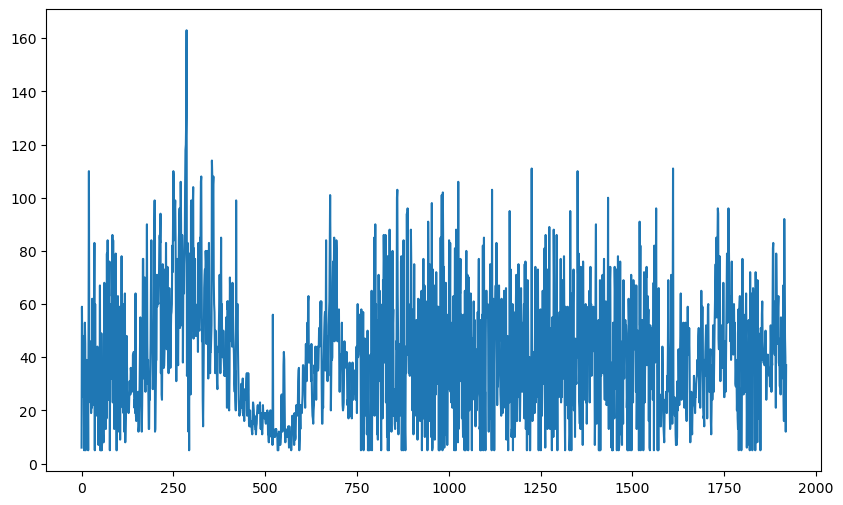

In [5]:
data['pm25'].plot(figsize=(10,6))

In [6]:
# Split the data into training, testing
train_size = int(0.7 * len(data))
test_size = int(0.3 * len(data))

train_data = data[:train_size]
test_data = data[train_size:]

# Kiểm tra kích thước của từng tập
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [7]:
# 3. Quá trình Training
model = VAR(train_data)
model_fitted = model.fit()

In [8]:
# 4. Quá trình testing 
# Dự đoán cho cả 'pm25' và 'o3'
y_pred = model_fitted.forecast(train_data.values[-model_fitted.k_ar:], steps=len(test_data))

In [9]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index = data.index[-1]
next_30_days_index = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)

# Dự đoán cho 30 ngày tiếp theo
y_next_30_days = model_fitted.forecast(model_fitted.endog[-model_fitted.k_ar:], steps=90)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 90 days:')
print(y_next_30_days)


Predicted closing prices for the next 90 days:
[[43.92073033 26.18640328]
 [42.29358532 25.29405423]
 [41.33062489 24.78642481]
 [40.77279442 24.49341342]
 [40.45027001 24.32405637]
 [40.26382654 24.22615809]
 [40.15604983 24.16956654]
 [40.09374783 24.13685293]
 [40.05773319 24.11794232]
 [40.03691437 24.10701074]
 [40.02487974 24.10069158]
 [40.01792293 24.09703869]
 [40.01390143 24.09492708]
 [40.01157675 24.09370643]
 [40.01023293 24.09300082]
 [40.00945611 24.09259292]
 [40.00900706 24.09235714]
 [40.00874748 24.09222083]
 [40.00859743 24.09214204]
 [40.00851069 24.0920965 ]
 [40.00846054 24.09207017]
 [40.00843156 24.09205495]
 [40.0084148  24.09204615]
 [40.00840512 24.09204107]
 [40.00839952 24.09203813]
 [40.00839628 24.09203643]
 [40.00839441 24.09203544]
 [40.00839333 24.09203488]
 [40.0083927  24.09203455]
 [40.00839234 24.09203436]
 [40.00839213 24.09203425]
 [40.00839201 24.09203418]
 [40.00839194 24.09203415]
 [40.0083919  24.09203413]
 [40.00839188 24.09203411]
 [40.008

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính RMSE
rmse = np.sqrt(mean_squared_error(test_data['pm25'], y_pred[:, 0]))
print('Testing RMSE:', rmse)

# Tính MAE
mae = mean_absolute_error(test_data['pm25'], y_pred[:, 0])
print('\nTesting MAE:', mae)

# Tính MAPE
mape = np.mean(np.abs((test_data['pm25'] - y_pred[:, 0]) / test_data['pm25'])) * 100
print('\nTesting MAPE:', mape)


Testing RMSE: 20.280506692978822

Testing MAE: 16.225908548399925

Testing MAPE: 82.59248648052659


In [11]:
test_data.index

RangeIndex(start=1344, stop=1920, step=1)

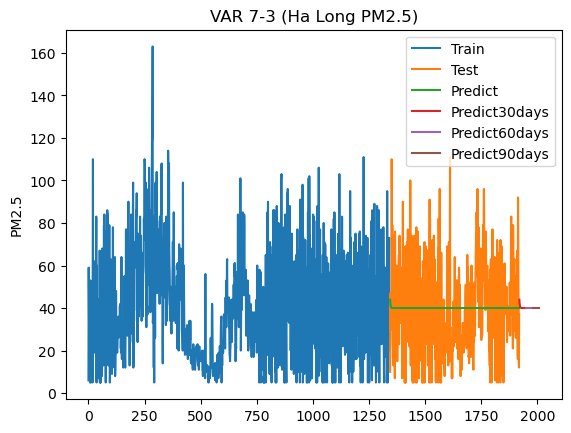

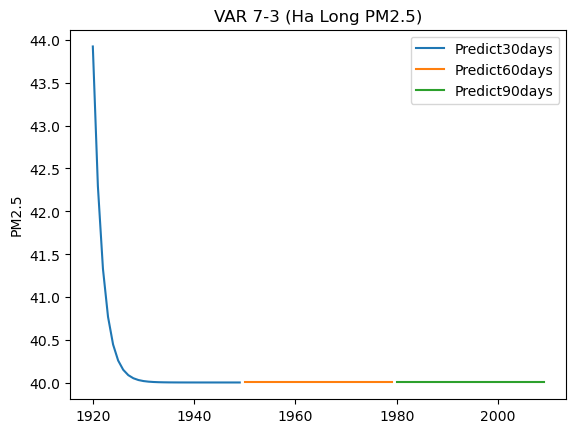

In [12]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['pm25'])
plt.plot(test_data.index, test_data['pm25'])
plt.plot(test_data.index, y_pred[:, 0])


last_data = pd.RangeIndex(start=last_index+1, stop=last_index+31, step=1)
plt.plot(last_data,y_next_30_days[0:30][:, 0])

last_data = pd.RangeIndex(start=last_index+31, stop=last_index+61, step=1)
plt.plot(last_data,y_next_30_days[30:60][:, 0])

last_data = pd.RangeIndex(start=last_index+61, stop=last_index+91, step=1)
plt.plot(last_data,y_next_30_days[60:90][:, 0])
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('VAR 7-3 (Ha Long PM2.5)')
plt.ylabel('PM2.5')
plt.show()


#DỰ đians 90 ngày
last_data = pd.RangeIndex(start=last_index+1, stop=last_index+31, step=1)
plt.plot(last_data,y_next_30_days[0:30][:, 0])

last_data = pd.RangeIndex(start=last_index+31, stop=last_index+61, step=1)
plt.plot(last_data,y_next_30_days[30:60][:, 0])

last_data = pd.RangeIndex(start=last_index+61, stop=last_index+91, step=1)
plt.plot(last_data,y_next_30_days[60:90][:, 0])
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('VAR 7-3 (Ha Long PM2.5)')
plt.ylabel('PM2.5')
plt.show()

